In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
from tqdm.auto import tqdm

In [2]:
BASE_PATH = "/kaggle/input/hms-harmful-brain-activity-classification"
SPEC_DIR = "/tmp/dataset/hms-hbac" # where to save the spectrograms after converting to numpy
os.makedirs(SPEC_DIR+'/train_spectrograms', exist_ok=True)
os.makedirs(SPEC_DIR+'/test_spectrograms', exist_ok=True)
class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
label2name = dict(enumerate(class_names))
name2label = {v:k for k, v in label2name.items()}

## Get data

In [4]:
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['eeg_path'] = f'{BASE_PATH}/train_eegs/'+df['eeg_id'].astype(str)+'.parquet'
df['spec_path'] = f'{BASE_PATH}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.parquet'
df['spec2_path'] = f'{BASE_PATH}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.parquet'
df['class_name'] = df.expert_consensus.copy()
df['class_label'] = df.expert_consensus.map(name2label)
display(df.head(2))

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec2_path,class_name,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,Seizure,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,Seizure,0


In [18]:
df[df.expert_consensus == 'LPD']

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec2_path,class_name,class_label
277,736446371,0,0.0,10397461,0,0.0,2926135348,29441,LPD,0,1,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,LPD,1
278,688312769,0,0.0,10397461,1,528.0,2971910547,29441,LPD,0,1,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,LPD,1
279,1768958569,0,0.0,10397461,2,746.0,1943001855,29441,LPD,0,7,3,0,0,1,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,LPD,1
280,1768958569,1,4.0,10397461,3,750.0,1542266364,29441,LPD,0,7,3,0,0,1,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,LPD,1
281,1041252567,0,0.0,10397461,4,1250.0,914021164,29441,LPD,0,1,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,LPD,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106784,1306668185,0,0.0,2147312808,0,0.0,1216355904,57480,LPD,0,3,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,LPD,1
106785,1306668185,1,2.0,2147312808,1,2.0,1835151100,57480,LPD,0,3,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,LPD,1
106786,1306668185,2,4.0,2147312808,2,4.0,230575779,57480,LPD,0,3,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,LPD,1
106787,1306668185,3,6.0,2147312808,3,6.0,1364999404,57480,LPD,0,3,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,LPD,1


<Axes: >

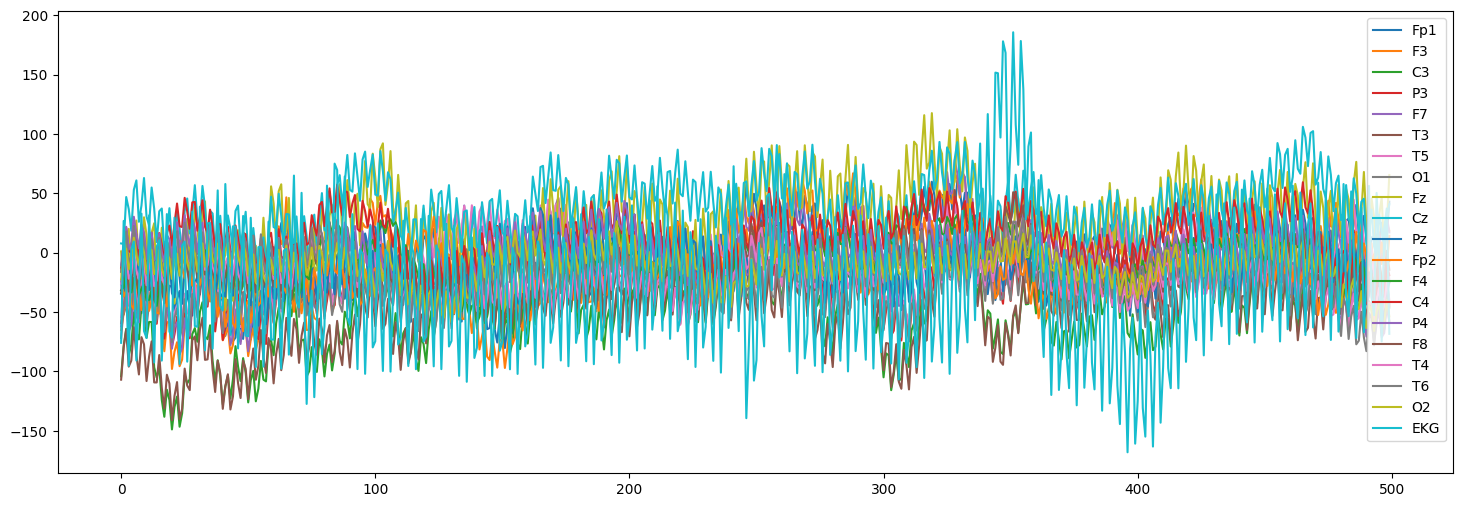

In [17]:

an_eeg = pd.read_parquet(df[df.expert_consensus == 'LPD'].iloc[0].eeg_path)
plt.figure(figsize=(18, 6))
plt.plot(an_eeg.iloc[:])
an_eeg.iloc[:500].plot(ax=plt.gca())

In [11]:
df.groupby("eeg_id").count()["eeg_sub_id"].value_counts()

eeg_sub_id
1      6324
2      1973
3      1430
4      1318
5       942
       ... 
101       1
85        1
236       1
210       1
226       1
Name: count, Length: 147, dtype: int64

In [19]:
import random
idx = random.randint(0, len(df))
df.iloc[idx]

eeg_id                                                                     3197941112
eeg_sub_id                                                                          3
eeg_label_offset_seconds                                                         14.0
spectrogram_id                                                             2043105002
spectrogram_sub_id                                                                  3
spectrogram_label_offset_seconds                                                 14.0
label_id                                                                   2606391600
patient_id                                                                      61693
expert_consensus                                                                  LPD
seizure_vote                                                                        3
lpd_vote                                                                            5
gpd_vote                                              

In [20]:
spec_parquet = pd.read_parquet(df.iloc[idx].spec_path)
spec_parquet.shape

(327, 401)

In [21]:
spec_parquet.columns[101:201]

Index(['RL_0.59', 'RL_0.78', 'RL_0.98', 'RL_1.17', 'RL_1.37', 'RL_1.56',
       'RL_1.76', 'RL_1.95', 'RL_2.15', 'RL_2.34', 'RL_2.54', 'RL_2.73',
       'RL_2.93', 'RL_3.13', 'RL_3.32', 'RL_3.52', 'RL_3.71', 'RL_3.91',
       'RL_4.1', 'RL_4.3', 'RL_4.49', 'RL_4.69', 'RL_4.88', 'RL_5.08',
       'RL_5.27', 'RL_5.47', 'RL_5.66', 'RL_5.86', 'RL_6.05', 'RL_6.25',
       'RL_6.45', 'RL_6.64', 'RL_6.84', 'RL_7.03', 'RL_7.23', 'RL_7.42',
       'RL_7.62', 'RL_7.81', 'RL_8.01', 'RL_8.2', 'RL_8.4', 'RL_8.59',
       'RL_8.79', 'RL_8.98', 'RL_9.18', 'RL_9.38', 'RL_9.57', 'RL_9.77',
       'RL_9.96', 'RL_10.16', 'RL_10.35', 'RL_10.55', 'RL_10.74', 'RL_10.94',
       'RL_11.13', 'RL_11.33', 'RL_11.52', 'RL_11.72', 'RL_11.91', 'RL_12.11',
       'RL_12.3', 'RL_12.5', 'RL_12.7', 'RL_12.89', 'RL_13.09', 'RL_13.28',
       'RL_13.48', 'RL_13.67', 'RL_13.87', 'RL_14.06', 'RL_14.26', 'RL_14.45',
       'RL_14.65', 'RL_14.84', 'RL_15.04', 'RL_15.23', 'RL_15.43', 'RL_15.63',
       'RL_15.82', 'RL_16.02'

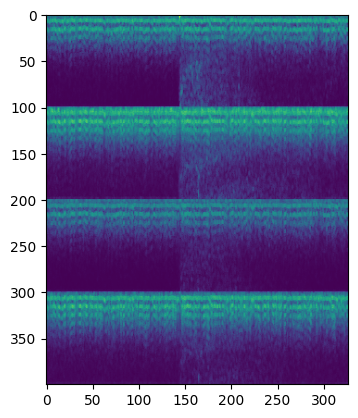

In [22]:
img = spec_parquet.iloc[:, 1:].values
img = np.log1p(img)
img = img.transpose()
img -= img.min()
img /= img.max() + 1e-4
plt.imshow(img)

In [52]:
df[df.eeg_id == df.iloc[idx].eeg_id]

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec2_path,class_name,class_label
36227,994398067,0,0.0,712491750,0,0.0,40062945,53102,LRDA,0,3,0,5,1,4,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,LRDA,3
36228,994398067,1,4.0,712491750,1,4.0,1304778180,53102,LRDA,0,3,0,5,1,4,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,LRDA,3
36229,994398067,2,6.0,712491750,2,6.0,831782695,53102,LRDA,0,3,0,5,1,4,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,LRDA,3
36230,994398067,3,8.0,712491750,3,8.0,735500483,53102,LRDA,0,3,0,5,1,4,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,LRDA,3
36231,994398067,4,10.0,712491750,4,10.0,142256434,53102,LRDA,0,3,0,5,1,4,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,LRDA,3
36232,994398067,5,12.0,712491750,5,12.0,1876572646,53102,LRDA,0,3,0,5,1,4,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,LRDA,3
36233,994398067,6,14.0,712491750,6,14.0,2220721903,53102,LRDA,0,3,0,5,1,4,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,LRDA,3
36234,994398067,7,16.0,712491750,7,16.0,1768087256,53102,LRDA,0,3,0,5,1,4,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,LRDA,3
36235,994398067,8,18.0,712491750,8,18.0,1054382857,53102,LRDA,0,3,0,5,1,4,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,LRDA,3
36236,994398067,9,20.0,712491750,9,20.0,1903761439,53102,LRDA,0,3,0,5,1,4,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,LRDA,3


In [ ]:
# Convert .parquet to .npy, from the "Starter Notebook"
import joblib
from tqdm.auto import tqdm
# Define a function to process a single eeg_id
def process_spec(spec_id, split="train"):
    spec_path = f"{BASE_PATH}/{split}_spectrograms/{spec_id}.parquet"
    spec = pd.read_parquet(spec_path)
    spec = spec.fillna(0).values[:, 1:].T # fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
    spec = spec.astype("float32")
    np.save(f"{SPEC_DIR}/{split}_spectrograms/{spec_id}.npy", spec)

# Get unique spec_ids of train and valid data
spec_ids = df["spectrogram_id"].unique()

# Parallelize the processing using joblib for training data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "train")
    for spec_id in tqdm(spec_ids, total=len(spec_ids))
)

# # Get unique spec_ids of test data
# test_spec_ids = test_df["spectrogram_id"].unique()

# # Parallelize the processing using joblib for test data
# _ = joblib.Parallel(n_jobs=-1, backend="loky")(
#     joblib.delayed(process_spec)(spec_id, "test")
#     for spec_id in tqdm(test_spec_ids, total=len(test_spec_ids))
# )